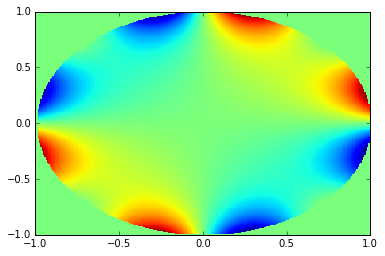

In [33]:
# a script to test the Laplace potentials and operators
# last modified: December 16, 2017

import geometry
import laplace
import numpy as np
import CalderonCalculusTest as CCT
import CalderonCalculusMatrices as CCM
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib import cm
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


N = 250

g  = geometry.ellipse(N,0,[1,1],[0,0])
gp = geometry.ellipse(N,1./6,[1,1],[0,0])
gm = geometry.ellipse(N,-1./6,[1,1],[0,0])

midpoints = [] 
for point in g['midpt']:
    midpoints.append((point[0],point[1]))

polygon = Polygon(midpoints)

# Laplacian has a kernel, so we use Lagrange multipliers
# to keep everything uniquely solvable
BIOs = laplace.CalderonCalculusLaplace(g,gp,gm)

V = np.ones((N+1,N+1))
V[0:N,0:N]=BIOs[0]
K = BIOs[1]
J = BIOs[2]
W = BIOs[3]
C = BIOs[4]
V[-1,-1] = 0

MATS = CCM.CalderonCalculusMatrices(g)

Q = MATS[0]
M = MATS[1]

# exact solution
#f = lambda x,y : x/(x**2+y**2)
#fx = lambda x,y : 1./(x**2+y**2) - 2*x**2/(x**2+y**2)**2
#fy = lambda x,y : -2.*x*y/(x**2+y**2)**2

#boundary data
f = lambda x,y : np.sin(2*np.pi*x*y)
fx = lambda x,y : 0*x
fy = lambda x,y : 0*y

# testing the RHS
RHS = CCT.test(f,[fx,fy],gp,gm)
beta0 = np.zeros((N+1,))
beta1 = np.zeros((N,))

beta0[0:N] = RHS[0]
beta1 = RHS[1]

# postprocessing
x = np.linspace(-1,1,250)
y = np.linspace(-1,1,250)

X,Y = np.meshgrid(x,y)

obs = np.array([X.flatten(), Y.flatten()]).T

POTs = laplace.LaplacePotentials(g,obs)

S = POTs[0]

# First experiment
eta = np.linalg.solve(V, beta0)
eta = eta[0:N,]
uh = np.dot(S,eta)

inPoly = np.zeros_like(uh)

pointNum = 0
for point in obs:
    pointNum += 1
    if polygon.contains(Point(point[0],point[1])):
        inPoly[pointNum]=1

uh[inPoly==0] = 0
uh = uh.reshape(N,N)

fig = plt.figure()
#ax = fig.gca()
#surf = ax.plot_surface(X, Y, uh, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax = plt.axes()
cont = plt.pcolormesh(X,Y,uh)
plt.show()

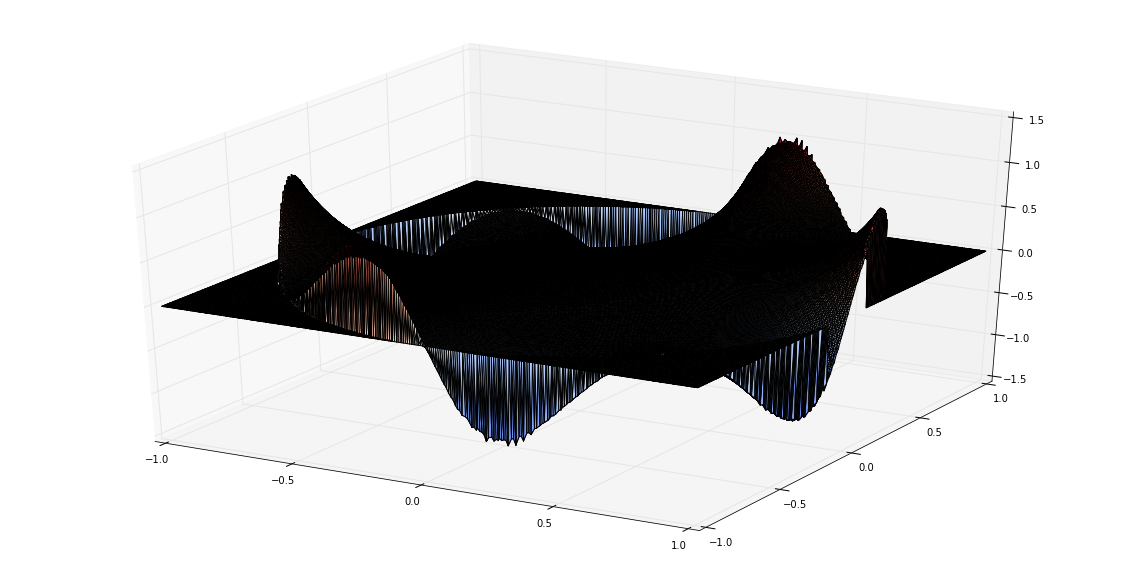

In [15]:
## now let's tringulate and plot it
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
from scipy.spatial import Delaunay

points = np.array([X.flatten(), Y.flatten(), uh.flatten()]).T

tri = Delaunay(points)

fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X.flatten().T, Y.flatten().T, uh.flatten().T, triangles=tri.simplices, cmap=plt.cm.coolwarm)
plt.show()

In [16]:
from stl import mesh

In [31]:
vertices = tri.points;
faces = tri.simplices;
# Create the mesh
sol = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
for i, f in enumerate(faces):
    for j in range(3):
        sol.vectors[i][j] = vertices[f[j],:]
        
sol.save('sol.stl')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  


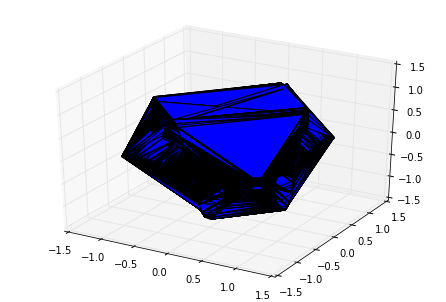

In [32]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

# Create a new plot
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)

# Load the STL files and add the vectors to the plot
your_mesh = mesh.Mesh.from_file('sol.stl')
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))

# Auto scale to the mesh size
scale = your_mesh.points.flatten(-1)
axes.auto_scale_xyz(scale, scale, scale)

# Show the plot to the screen
pyplot.show()